# Classificador de Laranjas -  Módulo de Aprendizado de Máquina

In [1]:
### 1. Importando as Dependências

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import pickle
import keras
from tqdm import tqdm
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils  import to_categorical
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D

### 2. Verificando Presença de uma GPU
O código abaixo realiza uma breve vericação no computador que está executando o código, vendo se este possui placa gráfica que esteja disponível para uso, caso haja, ele usará a mesma para o treinamento do modelo de dados, caso contrário, ele fará uso do processador da máquina para tal.

In [3]:
!pwd
tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices())
#???

/home/ita/Documentos/deep/classificador-laranjas
Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


### 3. Tratamento dos dados, utilizando visão computacional
Nesta função utlizamos o OpenCV, uma biblioteca de visão computacional, onde fazemos uso da função cvtColor(), função essa que converte uma imagem de um espaço de cores para outro. Também redimensionamos a imagem pra 100x100p, após fazer o carregamento desta. 

In [2]:
def load_rand():
    X=[]
    dir_path='./archive/dataset/train' #Diretorio dos dados de treinamento
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir) #rottenoranges vs freshoranges
        print(path_main)
        i=0
        for img_name in os.listdir(path_main): #Loop in each directory ['fresh', 'rotten']
            print(img_name)
            if i>=12: #Read 18 images each directory (36 in total)
                break
            img=cv2.imread(os.path.join(path_main,img_name)) #read image
            img=cv2.resize(img,(500,500)) #resize image 100x100 pixels
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #convert image
            X.append(img)
            i+=1
    return X

X=load_rand()

  0%|          | 0/2 [00:00<?, ?it/s]NORMAL
./archive/dataset/train/NORMAL
IM-0449-0001.jpeg
IM-0693-0001.jpeg
IM-0294-0001.jpeg
NORMAL2-IM-1360-0001.jpeg
IM-0750-0001.jpeg
IM-0464-0001.jpeg
IM-0210-0001.jpeg
NORMAL2-IM-0870-0001.jpeg
NORMAL2-IM-1108-0001.jpeg
IM-0177-0001.jpeg
NORMAL2-IM-1234-0001.jpeg
 50%|█████     | 1/2 [00:01<00:01,  1.10s/it]NORMAL2-IM-1142-0001-0002.jpeg
NORMAL2-IM-0959-0001.jpeg
PNEUMONIA
./archive/dataset/train/PNEUMONIA
person596_bacteria_2449.jpeg
person292_virus_600.jpeg
person947_virus_1618.jpeg
person1112_virus_1837.jpeg
person68_bacteria_337.jpeg
person370_bacteria_1690.jpeg
person422_virus_868.jpeg
person1133_virus_1865.jpeg
person1124_bacteria_3065.jpeg
person1470_bacteria_3830.jpeg
person275_bacteria_1291.jpeg
100%|██████████| 2/2 [00:01<00:00,  1.66it/s]person1074_bacteria_3012.jpeg
person475_bacteria_2022.jpeg



In [5]:
X=np.array(X)
X.shape #36 linhas de imagens de 100x100 pixels com profundidade 3 (RGB)
#onde R é Vermelho, G é Verde e B é Azul

(24, 500, 500, 3)

Carrega as imagens e coloca labels para elas

## Laranja Boa

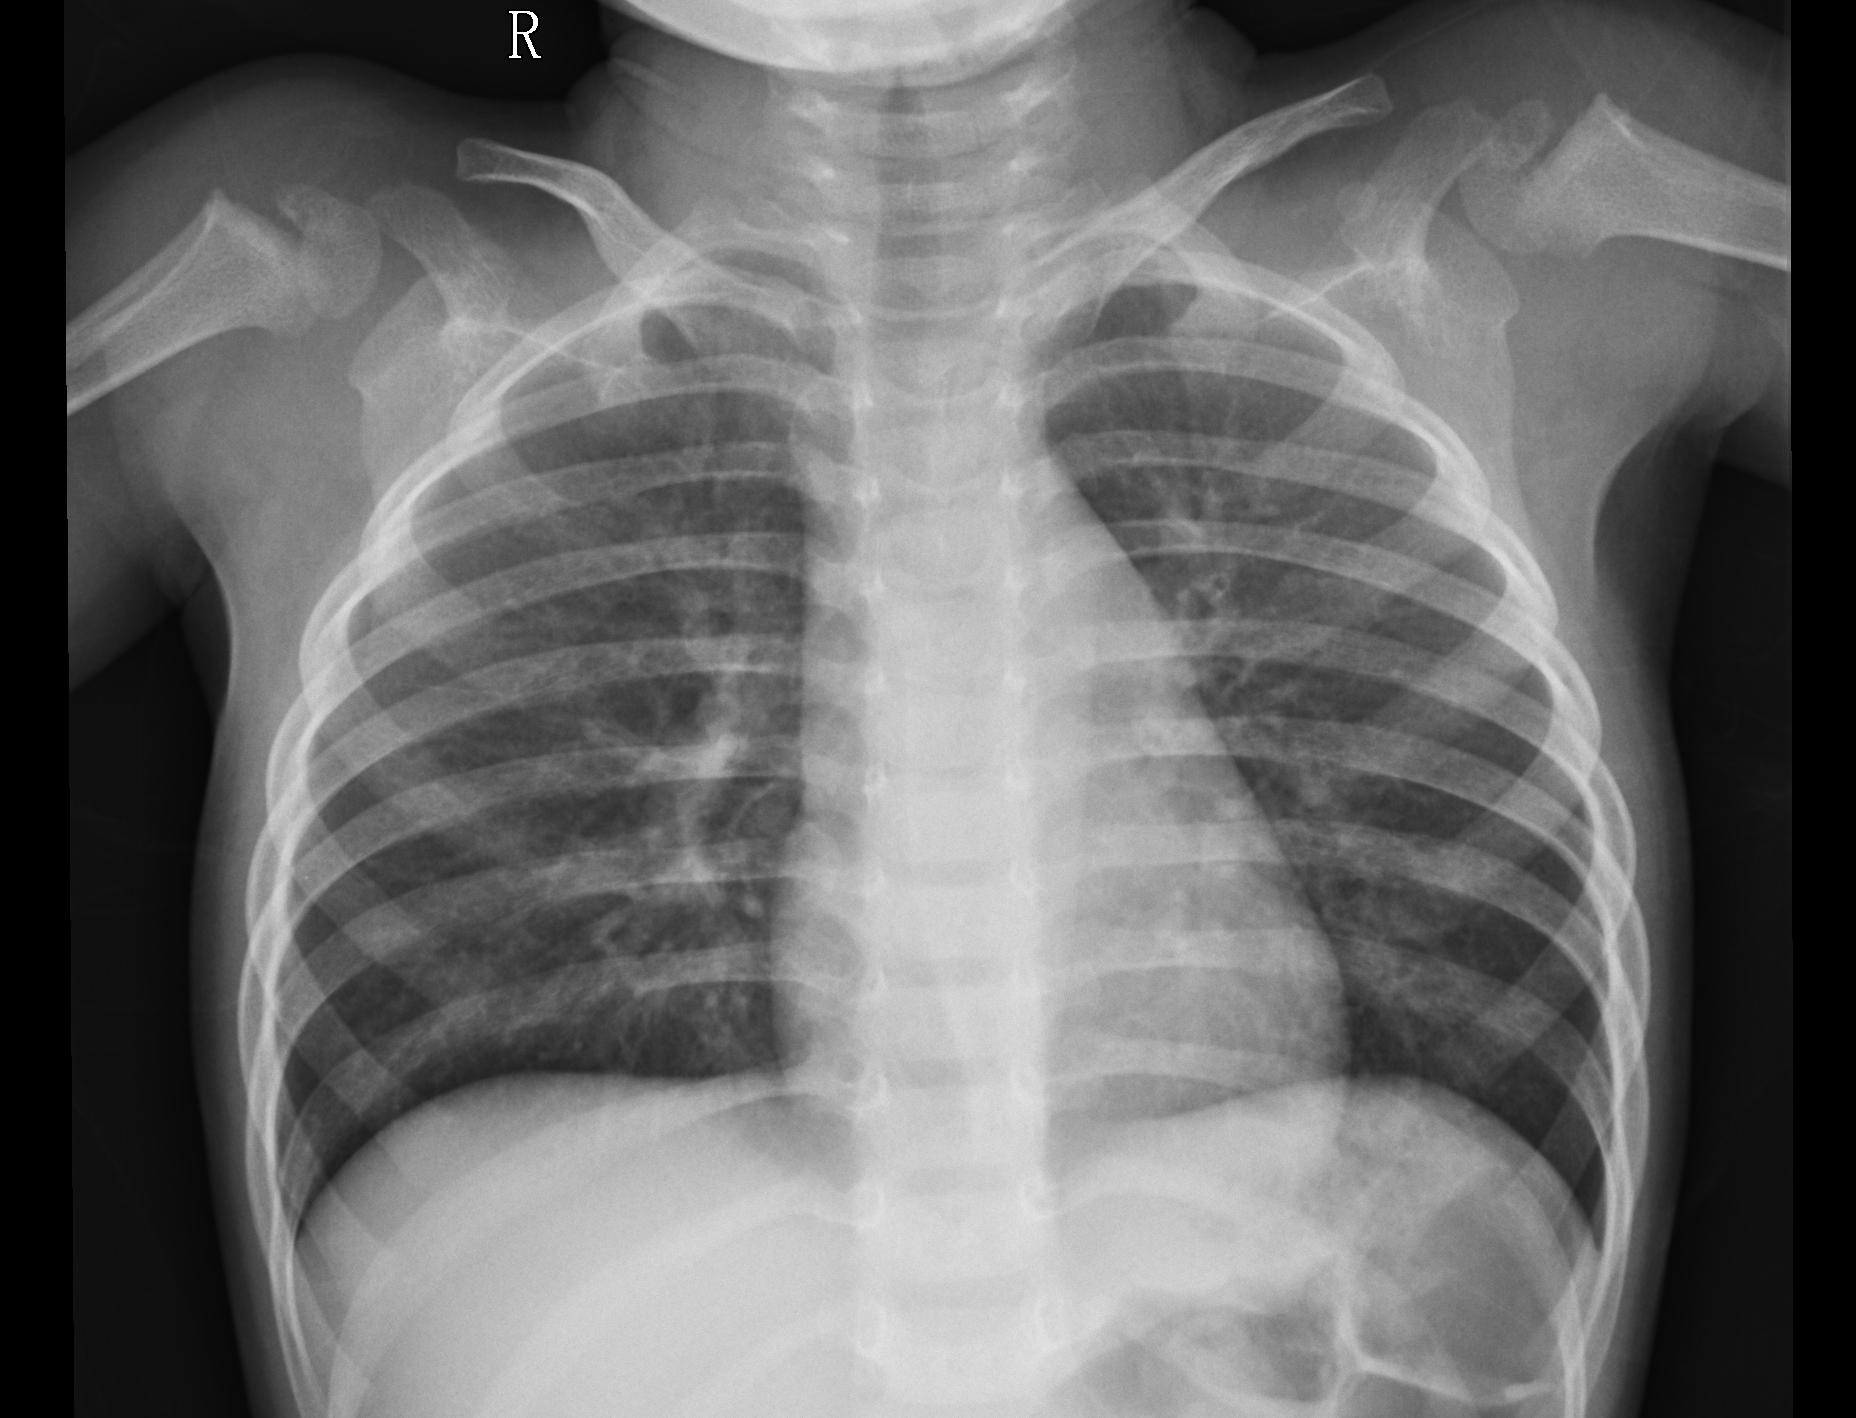

In [6]:
from IPython.display import Image
Image(filename='./archive/dataset/test/NORMAL/NORMAL2-IM-0027-0001.jpeg', width=255) 


## Laranja boa com manchas

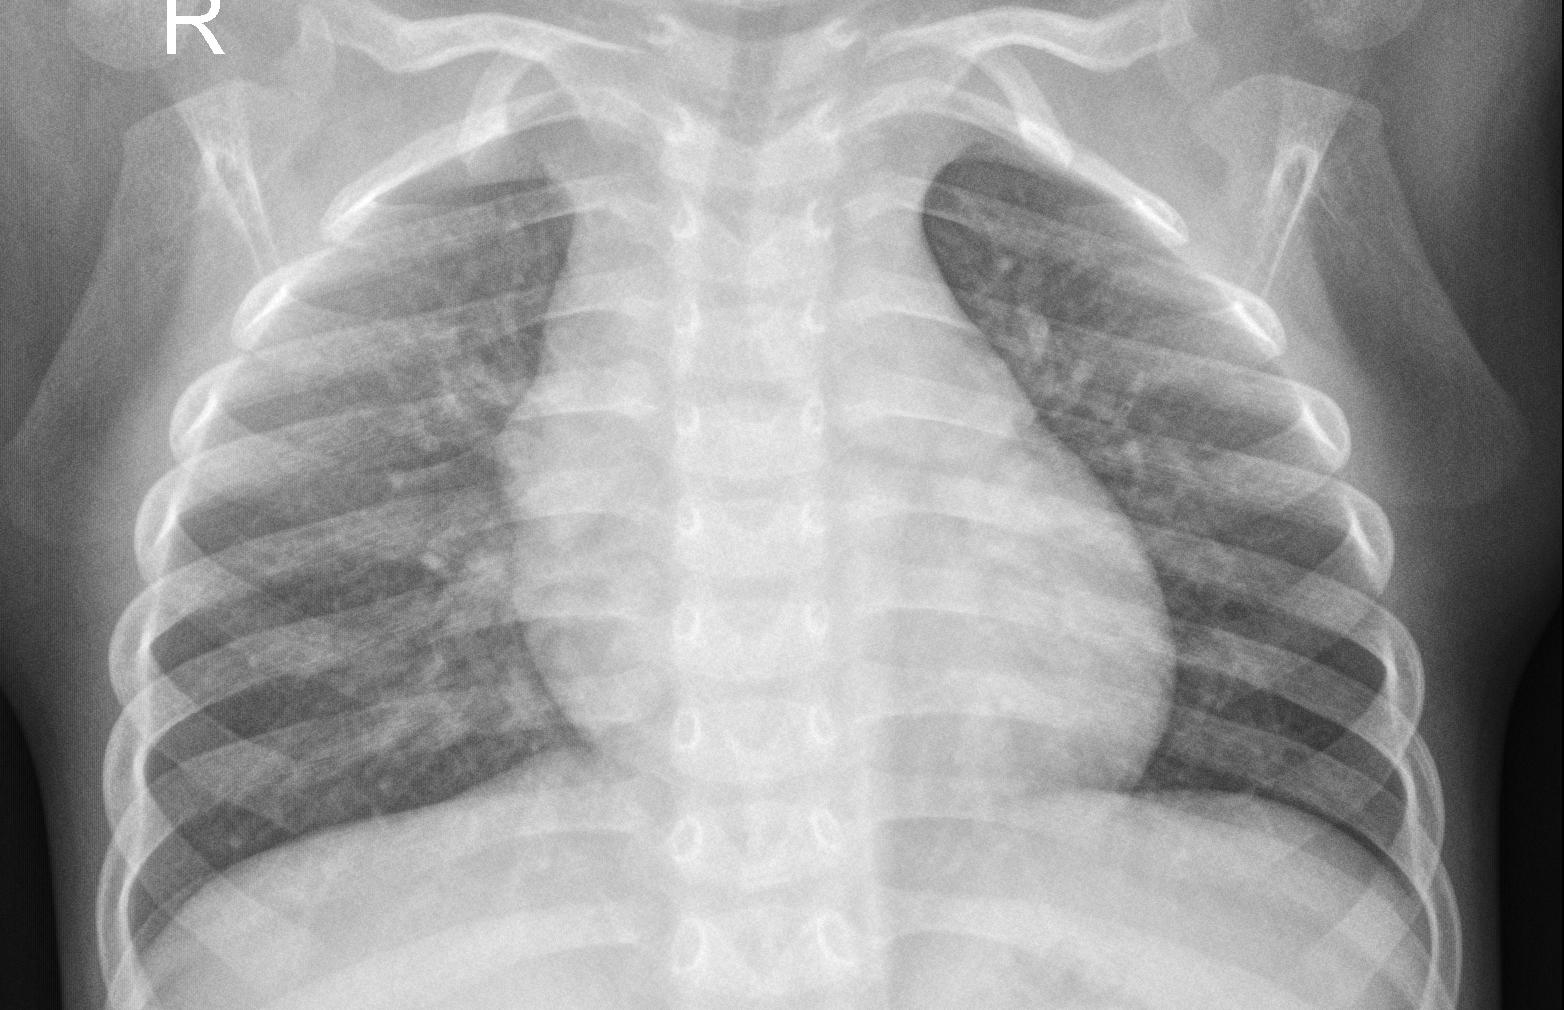

In [7]:
from IPython.display import Image
Image(filename='./archive/dataset/test/NORMAL/NORMAL2-IM-0271-0001.jpeg', width=255) 

## Laranja ruim

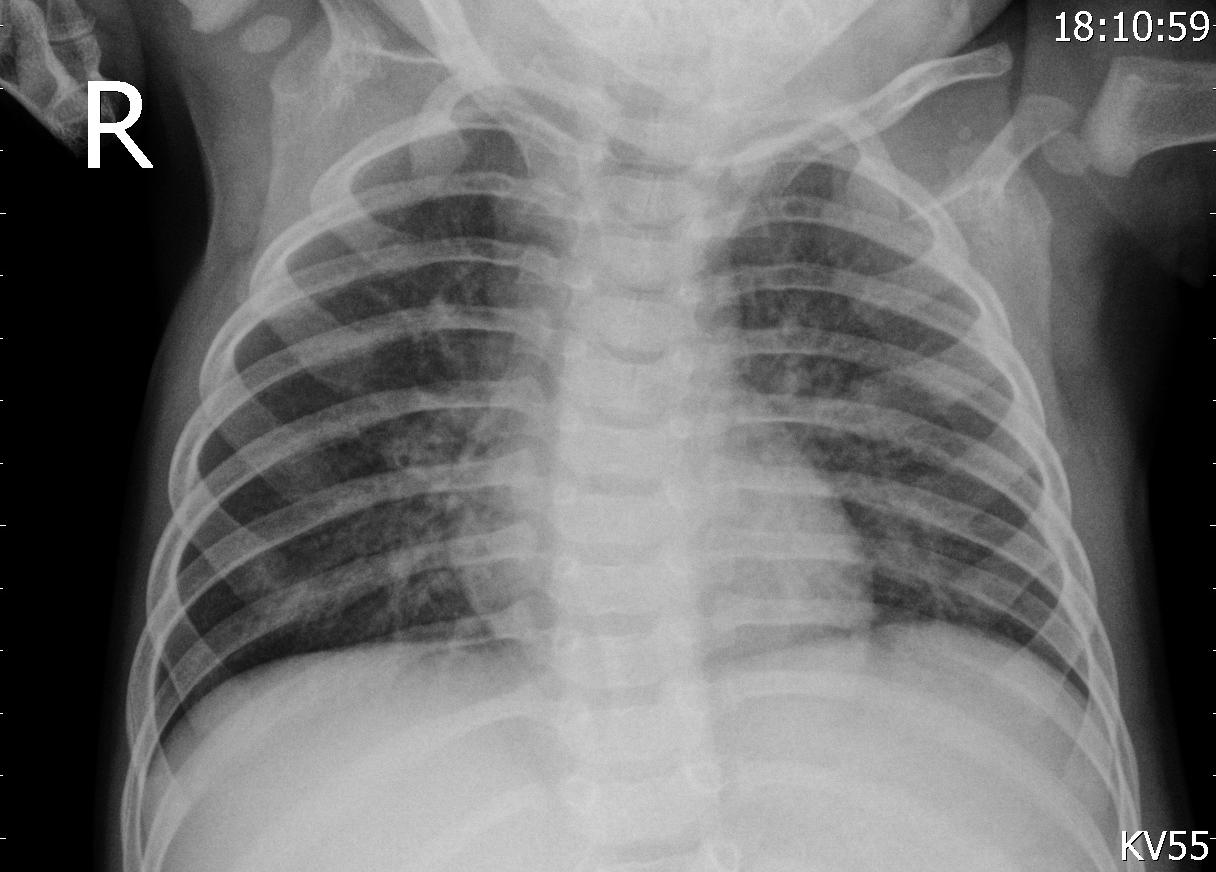

In [8]:
from IPython.display import Image
Image(filename='./archive/dataset/test/PNEUMONIA/person28_virus_62.jpeg', width=255) 

In [9]:
def load_rottenvsfresh():
    
    quality=['fresh', 'rotten', 'less']
    
    X,Y=[],[]
    z=[]
    #BOAS SEM MANCHAS -> LABEL 0
    #RUINS -> LABEL 1
    #BOA COM MANCHAS -> LABEL 2
    for cata in tqdm(os.listdir('./archive/dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('./archive/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(500,500))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO)
                z.append([img,0]) #fresh
        elif quality[1] in cata:
            path_main=os.path.join('./archive/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(500,500))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO)
                z.append([img,1]) #rotten
        else:
            path_main=os.path.join('./archive/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(500,500))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO)
                z.append([img,2]) #less
    
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [14]:
X,Y=load_rottenvsfresh()

100%|██████████| 5216/5216 [00:00<00:00, 1023173.21it/s]


In [15]:
Y=np.array(Y)
X=np.array(X)
y_ser=pd.Series(Y)
y_ser.value_counts()

2    5216
dtype: int64

In [16]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten', 'less']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('./archive/dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('./archive/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(500,500))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('./archive/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(500,500))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO)
                z.append([img,1]) #rotten
        else:
            path_main=os.path.join('./archive/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(500,500))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_TOZERO)
                z.append([img,2]) #less
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)        
    return X,Y

In [17]:
X_val,Y_val=load_rottenvsfresh_valset()


100%|██████████| 624/624 [00:00<00:00, 1676646.83it/s]


In [18]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

2    624
dtype: int64

 ### 0. Criando e estruturando nossa Rede Neural
 Neste trecho do código, iniciamos com a definição do modelo como um modelo Sequencial. O modelo sequencial é um modelo que se sobresai quando se trata de uma pilha de camadas simples, tendo cada camada exatamento um tensor de entrada e outro de saída.
 


In [19]:
#Para construir o modelo, precisamos criar a arquitetura usando Sequential().
model = Sequential()

#Em seguida, adicionamos a primeira camada, uma camada de convolução para extrair 
#recursos da imagem de entrada e criamos 32 recursos convolutos 3 x 3 ReLu, 
#também conhecidos como mapas de recursos. Como esta é a primeira camada, devemos inserir a forma 
#da dimensão que é uma imagem de 100 x 100 pixels com profundidade = 3 (RGB).
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', 
                 activation='relu', input_shape=(100,100,3)))

model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))

#A próxima camada será uma camada de pooling com um filtro de 2 x 2 pixels para obter o 
#elemento máximo dos mapas de feições. Isso reduz a dimensão dos mapas de recursos pela metade e 
#também é conhecido como subamostragem.
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

#Crie mais uma camada de convolução e camada de agrupamento como antes, mas sem o input_shape.
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
#Adicione uma camada de achatamento para reduzir a imagem a uma matriz linear, 
#também conhecida como um vetor de dimensão única, para alimentar e conectar-se à rede neural.
model.add(Flatten())
#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
#Agora crie uma rede neural onde a primeira camada tem 128 neurônios e a função de ativação ReLu .
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#Adicione uma camada de drop out com 30% de drop out.
model.add(Dropout(0.3))
#Crie a última camada desta rede neural usando a função softmax .
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [20]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=2, mode='max',
    min_lr=0.00002, cooldown=2)

check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='./rottenvs fresh.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

#compile o modelo, binary_crossentropy pois sao apenas 2 classes, otimizador adam e a precisao do modelo como metrica
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

Para agilização do processo de treinamento, diminuímos a dimensão da imagem, dividindo as matriz pela quantidade de colunas/linhas, visto que se trata de uma matriz quadrada.

Feito isso, partimos para a realização do fitting do dataset no modelo desenvolvido.

In [21]:
X=X/255.0
X_val=X_val/255.0

history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 25,
                 callbacks=[check_point])

Epoch 1/25
261/261 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9964
Epoch 00001: val_loss improved from inf to 366.79877, saving model to ./rottenvs fresh.h5
261/261 [==============================] - 162s 619ms/step - loss: 0.0265 - accuracy: 0.9964 - val_loss: 366.7988 - val_accuracy: 0.0000e+00
Epoch 2/25
261/261 [==============================] - ETA: 0s - loss: 3.4282e-10 - accuracy: 1.0000
Epoch 00002: val_loss improved from 366.79877 to 294.10226, saving model to ./rottenvs fresh.h5
261/261 [==============================] - 160s 614ms/step - loss: 3.4282e-10 - accuracy: 1.0000 - val_loss: 294.1023 - val_accuracy: 0.0000e+00
Epoch 3/25
261/261 [==============================] - ETA: 0s - loss: 1.9243e-07 - accuracy: 1.0000
Epoch 00003: val_loss improved from 294.10226 to 47.11306, saving model to ./rottenvs fresh.h5
261/261 [==============================] - 159s 611ms/step - loss: 1.9243e-07 - accuracy: 1.0000 - val_loss: 47.1131 - val_accuracy: 0.40

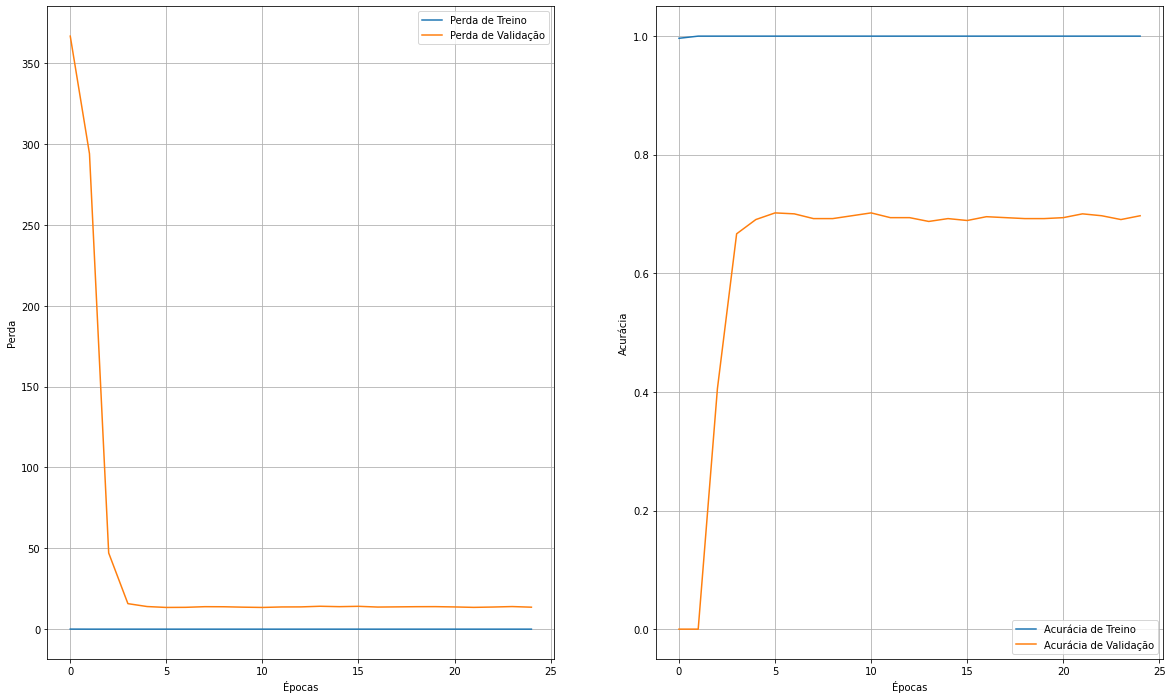

In [22]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.plot( history.history["loss"], label = "Perda de Treino")
plt.plot( history.history["val_loss"], label = "Perda de Validação")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.plot( history.history["accuracy"], label = "Acurácia de Treino")
plt.plot( history.history["val_accuracy"], label = "Acurácia de Validação")
plt.grid(True)
plt.legend()

Abaixo vemos uma avaliação do modelo e sua acurácia, esta resultando em 99.19% de precisão e perda de 0.0918

In [23]:
model.evaluate(X_val,Y_val)

20/20 [==============================] - 5s 227ms/step - loss: 13.5812 - accuracy: 0.6971


[13.58121395111084, 0.6971153616905212]

Feito a avaliação do modelo, que resultou em margens aceitáveis, salvamos o modelo em formato *.h5 para uso na API que integrará a máquina.

In [46]:
model.save('./rottenvsfresh.h5')

Abaixo validamos a integridade do arquivo salvo

In [45]:
new_model=load_model('./rottenvsfresh.h5')

In [26]:
### Testando com imagem aleatória

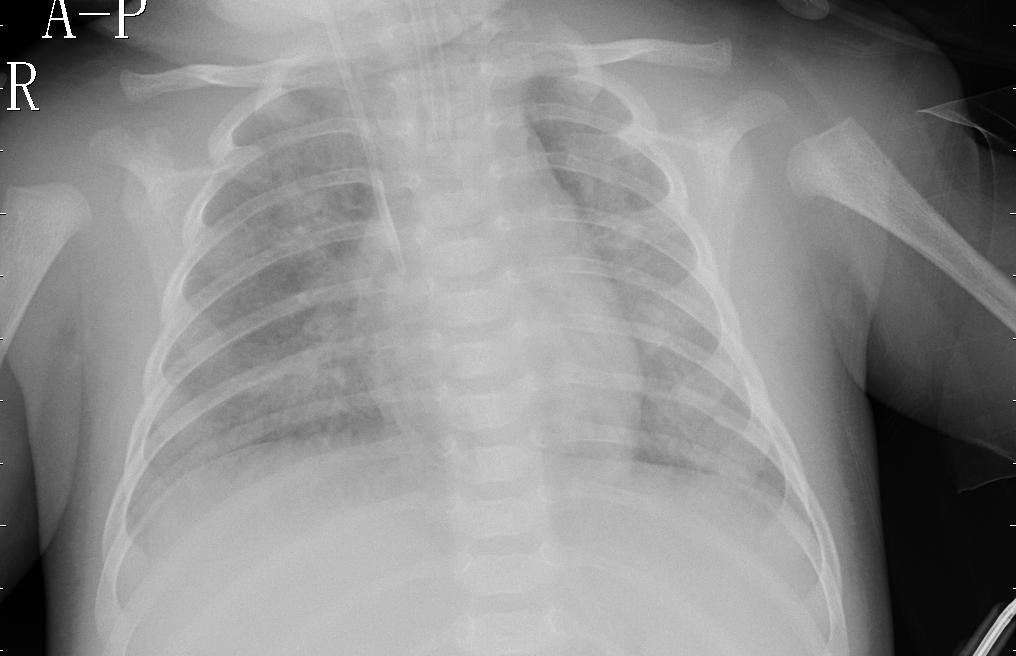

In [42]:
from IPython.display import Image
Image(filename='../archive/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg', width=255) 


In [43]:
I = []
img=cv2.imread('../archive/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg')
img=cv2.resize(img,(100,100))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
I.append(img)
NP_ARRAY = np.array(I)
X_VAL = NP_ARRAY/255.0
R = new_model.predict_classes(X_VAL)
if(R[0]==0):
    print('Laranja boa, sem manchas')
if(R[0]==1):
    print('Laranja ruim')
if(R[0]==2):
    print('Laranja boa, mas com manchas')
print(R[0])

Laranja ruim
1


In [41]:
res = new_model.evaluate(X_val,Y_val, return_dict = True)

20/20 [==============================] - 4s 202ms/step - loss: 13.5812 - accuracy: 0.0000e+00
